In [1]:
#imports

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import glob
import cv2
import re
import keras
from keras.models import Model
from keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from PIL import ImageFile 
import matplotlib.pyplot as plt
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report

# **Importing data**

In [44]:
data_dir = "../input/leafsnapdatasetfieldimages/field"
# print(data_dir)
root, dirs, files = next(os.walk(data_dir), ([],[],[]))
dirs.sort()
print(len(dirs))

184


# **Resising the image**

In [3]:
def resize(fl, img_height, img_width):
    img = cv2.imread(fl)
    resized = cv2.resize(img, (img_height, img_width))
    return resized

# Making  data

In [4]:
def get_data():
    X = []
    y = []
    classes = []
    dir_names = []
    
    for dir_name in dirs[:30]:
        class_name = dir_name.replace('_','')
        classes.append(class_name)
        
        dir_names.append(dir_name)
        
        path = os.path.join(data_dir,dir_name,'*.jpg')
        images = glob.glob(path)
        
        for fl in images:
            flbase = os.path.basename(fl)
            img = resize(fl, 64, 64)
            X.append(img)
            y.append(class_name)
            
    return X, y, classes,dir_names

In [5]:
X, y, classes,dir_names = get_data()

In [6]:
X = np.array(X)


print('Shape of X is',len(X))
print('Shape of Y is',len(y))

Shape of X is 1130
Shape of Y is 1130


In [7]:
class_dict={}
for i,class_name in enumerate(classes):
    class_dict[i] = class_name
    

print(len(class_dict))
    

30


# Sample images

Text(0.5, 1.0, '')

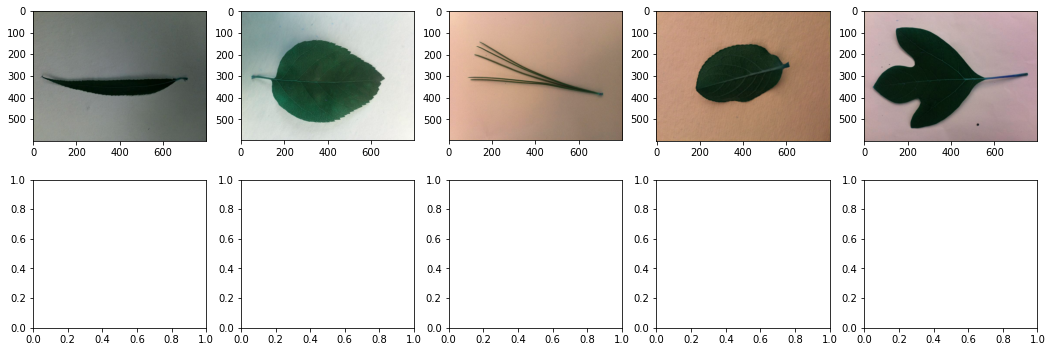

In [8]:
# Sample Image for each class
img_array=[]
for i in dir_names:
    path = os.path.join(data_dir, i)
    
    for img in os.listdir(path):
        imgs = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        img_array.append(imgs)
        break

f, axarr = plt.subplots(2,5,figsize=(18,6))  

axarr[0,0].imshow(img_array[0])
axarr[0,0].set_title(class_dict.get('0')) 

axarr[0,1].imshow(img_array[1])
axarr[0,1].set_title(class_dict.get('1')) 

axarr[0,2].imshow(img_array[2])
axarr[0,2].set_title(class_dict.get('2')) 

axarr[0,3].imshow(img_array[3])
axarr[0,3].set_title(class_dict.get('3')) 

axarr[0,4].imshow(img_array[4])
axarr[0,4].set_title(class_dict.get('4')) 

#axarr[1,0].imshow(img_array[5])
#axarr[1,0].set_title(class_dict.get('5')) 

#axarr[1,1].imshow(img_array[6])
#axarr[1,1].set_title(class_dict.get('6')) 

#axarr[1,2].imshow(img_array[7])
#axarr[1,2].set_title(class_dict.get('7')) 

#axarr[1,3].imshow(img_array[8])
#axarr[1,3].set_title(class_dict.get('8')) 

#axarr[1,4].imshow(img_array[9])
#axarr[1,4].set_title(class_dict.get('9'))

# Transforming labels to numerical using label encoder

In [9]:
#y = np_utils.to_categorical(y, num_classes=184,dtype ="int32")


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y_encoded = le.transform(y)

# Splitting into training and test data

In [10]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y_encoded,test_size = 0.3,stratify=y_encoded,random_state=42)

In [11]:
y_train_one_hot = np_utils.to_categorical(ytrain)
y_test_one_hot = np_utils.to_categorical(ytest)

In [12]:
Xtrain[5].shape

(64, 64, 3)

# Downloading ResNet50

In [13]:
# You only need to run this part once to download the model parameters 
modelResNet = ResNet50(include_top=False,  weights='imagenet',)

2021-12-07 00:04:53.950675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 00:04:54.049324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 00:04:54.050075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 00:04:54.051311: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step


In [14]:
for layer in modelResNet.layers:
    layer.trainable = False

# Extracting training features

In [15]:
%%time

feature_extractor_train=modelResNet.predict(Xtrain)

2021-12-07 00:04:58.421848: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-07 00:04:59.987490: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


CPU times: user 2.08 s, sys: 827 ms, total: 2.91 s
Wall time: 7.33 s


# Extracting testing features

In [16]:
%%time

feature_extractor_test=modelResNet.predict(Xtest)

CPU times: user 253 ms, sys: 18.7 ms, total: 272 ms
Wall time: 289 ms


In [17]:
training_features = feature_extractor_train.reshape(feature_extractor_train.shape[0], -1)
testing_features = feature_extractor_test.reshape(feature_extractor_test.shape[0], -1)

In [18]:
xtrain = training_features
xtest = testing_features

print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)

(791, 8192) (339, 8192) (791,) (339,)


# Converting Extracted Features to CSV file

In [19]:
df_X_train = pd.DataFrame(xtrain)
df_X_test = pd.DataFrame(xtest)

df_Y_train = pd.DataFrame(ytrain, columns=['type'])
df_Y_test = pd.DataFrame(ytest,columns=['type'])

In [20]:
df_Y_test.type.nunique()

30

### Find the best Parameters for the Logistic Regressor

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Define the train/test loss metric as MSE
def mse(y,ypr):
    return np.mean((y-ypr)**2)


# define shuffled KFold crossvalidation object
kf = KFold(n_splits=5, shuffle=False)

# define you scorer
scr = make_scorer(mse)

Create Pipelined Model testing

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

lr_mod1 = Pipeline([
    ('mod1', LogisticRegression(penalty='none',solver='newton-cg',C=0.01))
])


lr_mod2 = Pipeline([
    ('mod2',LogisticRegression(penalty="l2", C=1,solver="sag"))
])

lr_mod3 = Pipeline([
    ('mod3', LogisticRegression(penalty='l1', solver='liblinear', C=0.01))
])

In [23]:
# Calculate mean CV scores for each model 
CV1 = cross_val_score(lr_mod1, xtrain, ytrain, cv=kf, scoring=scr).mean()
CV3 = cross_val_score(lr_mod3, xtrain, ytrain, cv=kf, scoring=scr).mean()
CV2 = cross_val_score(lr_mod2, xtrain, ytrain, cv=kf, scoring=scr).mean()


print(f"CV loss (L2 penalised Model): {CV2}")
print(f"CV loss (NonPenalised LR Model): {CV1}")
print(f"CV loss (L1 Penalised Model): {CV3}")

CV loss (L2 penalised Model): 8.90762678130722
CV loss (NonPenalised LR Model): 7.945171562773663
CV loss (L1 Penalised Model): 40.92358092508558


##### We have a LR model with lowest CV loss

#### To find the best/Optimal C parameter to use with our Fave Model, we use a CV grid Search Tuning 

In [24]:
lam = np.exp(np.linspace(-1,1,10))
errs = np.zeros(len(lam))

for i in range(len(lam)):
    lr_mod2.set_params(mod2=LogisticRegression(C=lam[i], penalty='l2'))
    cvsc = cross_val_score(lr_mod2, xtrain, ytrain,cv=10,scoring = 'roc_auc')
    errs[i] = cvsc.mean()
    print(f"C-value (1/lam): {lam[i]} | nll: {errs[i]}")
    
a = np.array([lam,errs])
best_C = a[0,np.argmin(np.abs(a),axis=1)[1]]
print(f"Optimal lambda: {best_C}")

# Let's evaluate a final model with a confusion matrix, and one additional metric
lr_mod2.set_params(mod2=LogisticRegression(C=best_C, penalty='l2'))

C-value (1/lam): 0.36787944117144233 | nll: nan
C-value (1/lam): 0.45942582403592663 | nll: nan
C-value (1/lam): 0.5737534207374327 | nll: nan
C-value (1/lam): 0.7165313105737893 | nll: nan
C-value (1/lam): 0.8948393168143697 | nll: nan
C-value (1/lam): 1.1175190687418637 | nll: nan
C-value (1/lam): 1.3956124250860895 | nll: nan
C-value (1/lam): 1.7429089986334574 | nll: nan
C-value (1/lam): 2.176629931716248 | nll: nan
C-value (1/lam): 2.718281828459045 | nll: nan
Optimal lambda: 0.36787944117144233


Pipeline(steps=[('mod2', LogisticRegression(C=0.36787944117144233))])

In [25]:
final_mod = LogisticRegression(penalty="l2", C=best_C,solver="sag")
final_mod.fit(xtrain,ytrain)
ypr = final_mod.predict(xtest)
ypr

array([28,  8,  9, 26, 13,  3, 13, 28, 13, 24, 16, 16, 25, 28,  0, 12, 26,
       18, 10,  8,  8, 26, 22, 20, 22, 12, 13,  5, 24, 17,  6,  1, 22, 27,
       25,  9, 20, 18, 28, 28, 20, 20, 25,  7, 19,  7, 11, 23,  8, 12,  9,
       25,  8, 13, 25, 13, 26,  5,  5,  2, 25, 19, 17, 13, 28, 10,  2, 19,
       28, 22, 19, 18, 13, 25,  9, 15,  7, 11,  1,  4,  5, 17,  6, 18, 26,
       27, 13,  0, 10, 26, 18,  3, 24, 14, 16, 28,  3, 25,  1, 24, 13, 26,
       29,  3, 22, 26,  6, 20, 16, 20, 17, 22, 29, 15,  4, 15,  3,  2, 12,
       19, 25, 14, 25, 25, 15, 28, 15, 29, 11, 25, 19,  6,  0, 24,  1, 25,
        3, 18, 25, 24, 29, 18, 25, 19, 29,  0,  0,  6,  9,  8,  0, 16, 25,
        4, 25,  5, 25, 13, 14, 19,  6, 13, 13,  5,  8, 20,  6,  9, 14,  2,
       13,  7,  1, 28, 11, 23, 28,  8,  6, 14,  6, 17,  1, 16, 18, 15, 24,
        6,  6, 18,  8, 29,  6,  4,  5, 13,  3, 13, 25,  3, 18,  4,  8,  6,
        6, 10,  4, 12,  2, 26, 19, 10, 12, 18, 22, 21,  5, 18,  3, 25,  7,
        0,  9, 14, 14, 26

In [26]:
print("Coefs: ", final_mod.coef_)
print("\nIntercept: ",final_mod.intercept_)

Coefs:  [[ 1.4660020e-03 -1.7551770e-03 -4.4176818e-04 ... -7.6993427e-04
  -1.0189816e-03  1.0062509e-03]
 [-1.1856676e-03  6.7669270e-04 -1.0228923e-03 ... -7.4231522e-03
  -4.1318193e-04  5.0657435e-04]
 [-3.8748162e-04  6.4639741e-04 -1.0690473e-03 ... -8.3557535e-03
  -1.8062472e-04  8.0908037e-04]
 ...
 [ 3.8328869e-03  1.1383202e-03  2.3539551e-06 ...  8.1878854e-03
  -8.4474846e-04 -4.2046496e-04]
 [-1.7441435e-03 -4.4503997e-04 -4.9743819e-04 ...  1.3529148e-02
  -1.0852747e-03  1.0537114e-03]
 [-6.8048591e-04  5.4139420e-03 -2.4031427e-04 ...  3.6034049e-03
   5.7584798e-04 -1.7061360e-04]]

Intercept:  [-1.3258457e-04 -3.0762600e-04  6.5289991e-05  1.5013464e-04
 -7.6967053e-04 -1.5346947e-04 -4.7297330e-04 -5.3850608e-04
  2.1489291e-03  1.8701395e-04 -1.3377925e-06 -5.5971678e-04
 -2.0736313e-04  1.2973386e-04 -4.2294691e-04  6.0361141e-05
  8.7809327e-05 -6.5302959e-04 -2.4047848e-05  5.8442989e-04
  4.4601859e-04  2.9529707e-04 -4.0098610e-05 -1.7825661e-04
  3.6903506e-

In [27]:
# Find the prediction accuracy score
acc = accuracy_score(ytest,ypr)
print("Accuracy :", acc)

# Find the recall, precision scores
rec = recall_score(ytest,ypr, average='macro')
prec = precision_score(ytest,ypr, average='macro')
# print("\n")
print(f"Recall: {rec}, \nPrecision: {prec}")

Accuracy : 0.9351032448377581
Recall: 0.9126443001443002, 
Precision: 0.9206830206830205


<bound method Figure.tight_layout of <Figure size 720x504 with 1 Axes>>

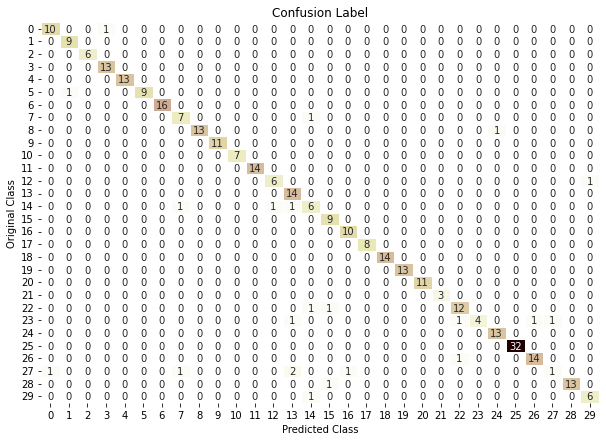

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax1 = plt.subplots(1,1, figsize=(10,7))
conf = confusion_matrix(ytest,ypr)
sns.heatmap(conf, annot=True, cbar=False, fmt="d", linewidths=0.5, cmap="pink_r", ax=ax1)
ax1.set_title("Confusion Label")
ax1.set_xlabel("Predicted Class")
ax1.set_ylabel("Original Class")
fig.tight_layout

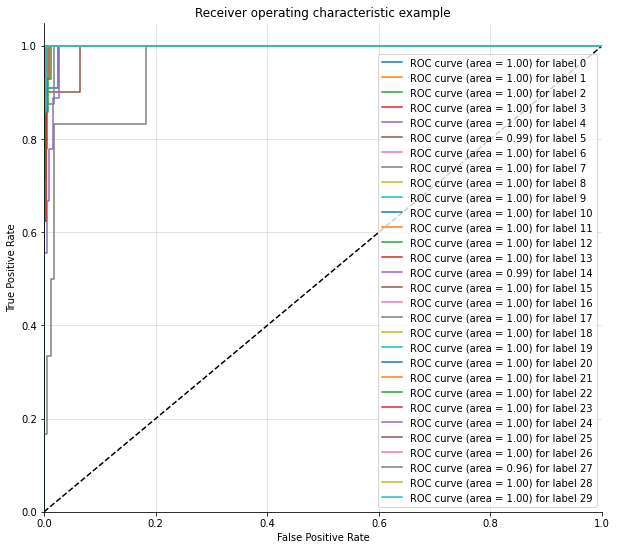

<Figure size 432x288 with 0 Axes>

In [29]:
def plot_multiclass_roc(clf, xtest, ytest, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(xtest)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(ytest, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    plt.savefig('resnet_LR_roc.png')
plot_multiclass_roc(final_mod, xtest, ytest, n_classes=30, figsize=(10,9))

In [30]:
print(classification_report(ytest, ypr, digits=3))

              precision    recall  f1-score   support

           0      0.909     0.909     0.909        11
           1      0.900     1.000     0.947         9
           2      1.000     1.000     1.000         6
           3      0.929     1.000     0.963        13
           4      1.000     1.000     1.000        13
           5      1.000     0.900     0.947        10
           6      1.000     1.000     1.000        16
           7      0.778     0.875     0.824         8
           8      1.000     0.929     0.963        14
           9      1.000     1.000     1.000        11
          10      1.000     1.000     1.000         7
          11      1.000     1.000     1.000        14
          12      0.857     0.857     0.857         7
          13      0.778     1.000     0.875        14
          14      0.667     0.667     0.667         9
          15      0.818     1.000     0.900         9
          16      0.909     1.000     0.952        10
          17      1.000    